In [1]:
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from scipy.misc import imresize

%matplotlib inline
import pylab as pl
from IPython import display
import time

torch.cuda.set_device(0)

In [2]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize),
            nn.ReLU()
        )
        
    def forward(self, inp):
        return self.layers(inp)

class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.AvgPool2d(10)
        )
        
    def forward(self, inp):
        out = self.process(inp[:,:3,:,:])
        return out.view(out.size(0),-1)
    
class PREDICTOR(nn.Module):
    def __init__(self):
        super(PREDICTOR, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, inp, way, tshot):
        assert inp.size(0)%way == 0,"Error: classes are not the same size!"
        support = inp[:way*tshot].view(way,tshot,-1)
        centroids = torch.mean(support, 1).view(way,-1)
        distmat = torch.sum((centroids.unsqueeze(0)-inp[way*tshot:].unsqueeze(1))**2,2).squeeze().neg()
        probs = self.sm(distmat)
        return probs

In [3]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225])])
raw = torch.load('/data/imagenet/photos-annotated-0-augmented.pth')
trainset = [[[preprocess(r[1]),torch.Tensor(imresize(r[2],(10,10))).unsqueeze(0)/255] 
            for r in cat] for cat in raw]
raw = torch.load('/data/imagenet/photos-annotated-0-test.pth')
testset = [[[preprocess(r[1]),torch.Tensor(imresize(r[2],(10,10))).unsqueeze(0)/255] 
            for r in cat] for cat in raw]
del raw

/home/dww78/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/home/dww78/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


In [4]:
def batchmaker(way,trainshot,testshot,theset):
    classes = np.random.choice(len(theset),way,replace=False)
    li = [[[theset[cl][i][0].view(1,3,84,84),theset[cl][i][1].view(1,10,10)] for i in 
           np.random.choice(len(theset[cl]),trainshot+testshot,replace=False)]
          for cl in classes]
    support = torch.cat([torch.cat([p[0] for p in t[:trainshot]],dim=0) for t in li],dim=0)
    query = torch.cat([torch.cat([p[0] for p in t[trainshot:]],dim=0) for t in li],dim=0)
    qtargs = torch.LongTensor([i//testshot for i in range(testshot*way)])
    out = torch.cat([support, query], dim=0)
    return(Variable(out).cuda(), Variable(qtargs).cuda())

def evaluate(embed,model,criterion,way,trainshot,testshot,reps,theset):
    masktracker = 0
    losstracker = 0
    acctracker = 0
    acclist = []
    for i in range(reps):
        with torch.no_grad():
            x,qt = batchmaker(way,trainshot,testshot,theset)
            preds = model(embed(x),way,trainshot)

            # Val loss
            loss = criterion(preds,qt)
            losstracker += loss.item()

            # Val accuracy
            _,bins = torch.max(preds,1)
            acc = torch.sum(torch.eq(bins,qt)).item()/testshot/way
            acctracker += acc
            acclist.append(acc)
    return losstracker/reps,acctracker/reps

trainway = 20
bsize = 20
trainshot = [16,8,4,2,1]
evalway = 5
evaltrainshot = [16,8,4,2,1]
evaltestshot = 15
reps = 100

In [5]:
embed = ENCODER().cuda()
model = PREDICTOR().cuda()
embed.train()
model.train()
losstracker,evallosstracker,evalacctracker = [],[],[]
optimizer = None
nweights = sum([i.numel() for i in list(embed.parameters())])
print(nweights," parameters in neural net.")

113088  parameters in neural net.


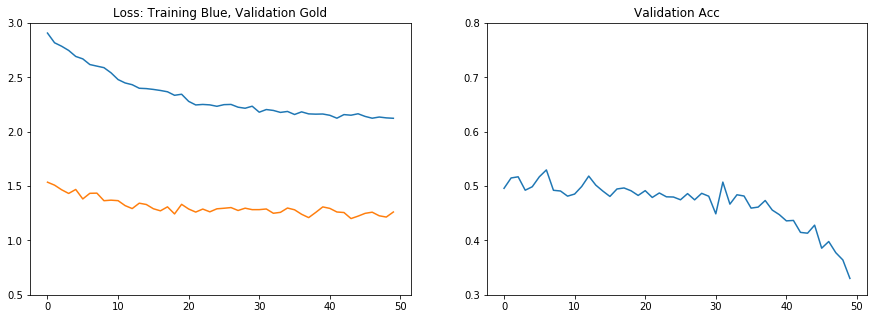

Train loss is: 2.1235853576660157
Validation accuracy is: 0.49586666666666657
Validation loss is: 1.2616168093681335

55598.1938521862
0.00 hours to completion
1
16
8
4
2
1


In [6]:
# TRAIN!
criterion = nn.NLLLoss().cuda()
vbity = 200 #1024
epoch = 2000 #8192
ensemble = 8

accgrid = [[0 for _ in range(len(evaltrainshot))] for _ in range(len(trainshot))]
for i in range(len(trainshot)):
    tshot = trainshot[i]
    
    start = time.time()
    for e in range(ensemble):
        runningloss = 0
        embed = ENCODER().cuda()
        model = PREDICTOR().cuda()
        embed.train()
        model.train()
        losstracker,evallosstracker,evalacctracker = [],[],[]
        optimizer = None
        for it in range(5*epoch):
            if it%10==0:
                print(it)

            # Build batch
            support, targs = batchmaker(trainway,tshot,bsize-tshot,trainset)

            # Predict
            embed.zero_grad()
            model.zero_grad()
            preds = model(embed(support),trainway,tshot)

            # Calculate Loss
            loss = criterion(preds, targs)
            runningloss += loss

            # Backprop
            if it%epoch == 0:
                optimizer = optim.Adam(embed.parameters(),lr=.001/(2**(it//epoch)))
            loss.backward()
        #     nn.utils.clip_grad_norm(model.parameters(), 1)
            optimizer.step()

            # Report
            if it%vbity == vbity-1:
                display.clear_output(wait=True)

                losstracker.append(runningloss.item()/vbity)
                evalloss, evalacc = evaluate(embed,model,criterion,evalway,tshot,evaltestshot,reps,testset)
                evallosstracker.append(evalloss)
                evalacctracker.append(evalacc)

                pl.figure(1,figsize=(15,5))
                pl.subplot(1,2,1)
                pl.plot(losstracker)
                pl.plot(evallosstracker)
                pl.ylim((.5,3))
                pl.title("Loss: Training Blue, Validation Gold")
                pl.subplot(1,2,2)
                pl.plot(evalacctracker[::-1])
                pl.ylim((0.3,.8))
                pl.title("Validation Acc")
                pl.show()

                print("Train loss is: "+str(runningloss.item()/vbity)+
                      "\nValidation accuracy is: "+str(evalacc)+
                      "\nValidation loss is: "+str(evalloss)+"\n")
                runningloss = 0
                print(time.time()-start)
                print("%.2f hours to completion"%( (time.time()-start)/(it+1+5*epoch*e)*(5*epoch-it+(ensemble-e-1)*5*epoch)/3600 ))
                print(tshot)
        
        for j in range(len(evaltrainshot)):
            etshot = evaltrainshot[j]
            _,acc = evaluate(embed,model,criterion,evalway,etshot,evaltestshot,10000,testset)
            accgrid[i][j] += acc
            print(etshot)

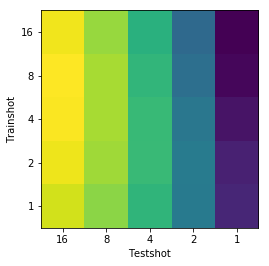

In [7]:
# accgrid = [[0.7341796666667659, 0.70159866666676, 0.646501333333409, 0.5668593333333634, 0.47451933333333185], [0.7348540000000997, 0.7049280000000943, 0.6569880000000795, 0.5816866666667027, 0.4857456666666666], [0.7238360000000981, 0.6974740000000922, 0.6511793333334087, 0.5764850000000334, 0.4871353333333323], [0.6988606666667594, 0.6675903333334171, 0.6251016666667302, 0.5520280000000194, 0.4625800000000016], [0.6411476666667429, 0.6102233333333918, 0.5576946666666918, 0.48676433333333197, 0.4078953333333627]]
accgrid = np.array(accgrid)
pl.figure()
pl.imshow(accgrid) #, vmin=.4, vmax=.75)
pl.ylabel('Trainshot')
pl.xlabel('Testshot')
pl.xticks(list(range(len(evaltrainshot))), evaltrainshot)
pl.yticks(list(range(len(evaltrainshot))), evaltrainshot)
pl.show()

In [8]:
print(accgrid/ensemble)

[[0.72654267 0.69166767 0.636442   0.560021   0.47112467]
 [0.73213017 0.6983555  0.64339283 0.56683917 0.47534017]
 [0.73057267 0.69825417 0.64706883 0.5744125  0.4853125 ]
 [0.72508083 0.69441717 0.64804233 0.5799435  0.49457983]
 [0.71448317 0.68710317 0.64195517 0.57813183 0.49885083]]


In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>

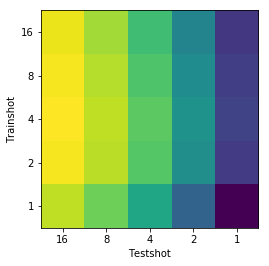

In [9]:
# accgrid = [[0.7341796666667659, 0.70159866666676, 0.646501333333409, 0.5668593333333634, 0.47451933333333185], [0.7348540000000997, 0.7049280000000943, 0.6569880000000795, 0.5816866666667027, 0.4857456666666666], [0.7238360000000981, 0.6974740000000922, 0.6511793333334087, 0.5764850000000334, 0.4871353333333323], [0.6988606666667594, 0.6675903333334171, 0.6251016666667302, 0.5520280000000194, 0.4625800000000016], [0.6411476666667429, 0.6102233333333918, 0.5576946666666918, 0.48676433333333197, 0.4078953333333627]]
accgrid = np.array(accgrid)
pl.figure()
pl.imshow(accgrid) #, vmin=.4, vmax=.75)
pl.ylabel('Trainshot')
pl.xlabel('Testshot')
pl.xticks(list(range(len(evaltrainshot))), evaltrainshot)
pl.yticks(list(range(len(evaltrainshot))), evaltrainshot)
pl.show()

In [10]:
print(accgrid/ensemble)

[[0.71649244 0.68378578 0.633136   0.55990356 0.47339956]
 [0.72124222 0.691248   0.64242667 0.57019511 0.48025022]
 [0.72524    0.69684222 0.64911333 0.57773644 0.48613689]
 [0.72167467 0.69372978 0.64609289 0.57275289 0.47836844]
 [0.69617378 0.65941689 0.60103689 0.52057022 0.42440089]]


In [10]:
np.mean(evalacctracker[-50:])

0.56243733333333346

In [15]:
name = 'meanpool'
torch.save((embed,model,losstracker,evallosstracker,evalacctracker),'../saved_models/'+name+'.pth')
torch.save(embed.cpu().state_dict(),'../saved_models/'+name+'_cpu.pth')

/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ENCODER. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type PREDICTOR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
embed,model,losstracker,evallosstracker,evalacctracker = torch.load('saved_models/naive_4.pth')

In [ ]:
Paper model achieves (over last 1000):
    0.71156711111111126
after 188500 iters

In [213]:
support = supportmaker(nclass,shot)
inp = inpmaker(nclass)
embeds = embed(support)
query = embed(inp)
model(embeds,query)

Variable containing:
-6.7075e-03 -5.0079e+00 -2.7911e+01
-2.9057e+00 -5.6263e-02 -4.5704e+01
-1.8272e+01 -4.3870e+01 -1.1600e-08
[torch.FloatTensor of size 3x3]